# Final Analysis and ML Model building

### Importing Libraries

In [4]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import xgboost as xgb
import shap
import joblib

### Importing Dataset

In [5]:
df=pd.read_csv('final_dataset.csv')
df

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type,admission_src,med_changes,admission_src_grouped
0,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,No,No,Ch,Yes,0,Emergency,Emergency Room,1,Emergency Room
1,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,Yes,0,Emergency,Emergency Room,0,Emergency Room
2,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,No,No,Ch,Yes,0,Emergency,Emergency Room,1,Emergency Room
3,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,No,No,Ch,Yes,0,Emergency,Emergency Room,0,Emergency Room
4,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,No,No,No,No,Yes,0,Urgent,Clinic Referral,0,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98048,443847548,100162476,AfricanAmerican,Male,[70-80),1,3,7,3,51,...,No,No,No,Ch,Yes,0,Emergency,Emergency Room,1,Emergency Room
98049,443847782,74694222,AfricanAmerican,Female,[80-90),1,4,5,5,33,...,No,No,No,No,Yes,0,Emergency,Transfer from a Skilled Nursing Facility (SNF),0,Other
98050,443854148,41088789,Caucasian,Male,[70-80),1,1,7,1,53,...,No,No,No,Ch,Yes,0,Emergency,Emergency Room,1,Emergency Room
98051,443857166,31693671,Caucasian,Female,[80-90),2,3,7,10,45,...,No,No,No,Ch,Yes,0,Urgent,Emergency Room,1,Emergency Room


### Feature Selection and Final Preparation

In [6]:
diag_mapping = {
    'Circulatory': list(range(390, 460)) + [785], 'Respiratory': list(range(460, 520)) + [786],
    'Digestive': list(range(520, 580)) + [787], 'Diabetes': [250], 'Injury': list(range(800, 1000)),
    'Musculoskeletal': list(range(710, 740)), 'Neoplasms': list(range(140, 240)),
}
def map_diag_codes(code):
    try:
        code_val = float(code)
        for category, code_range in diag_mapping.items():
            if int(code_val) in code_range: return category
        return 'Other'
    except (ValueError, TypeError): return 'Other'
df['diag_1_category'] = df['diag_1'].apply(map_diag_codes)

In [10]:
features_to_drop = [
    'encounter_id','patient_nbr','admission_type_id','discharge_disposition_id',
    'admission_source_id','diag_1','diag_2','diag_3','admission_src_grouped'
]
df_model = df.drop(columns=features_to_drop, errors='ignore')


In [ ]:
X = df_model.drop('readmitted',axis=1)
y = df_model['readmitted'].replace({'<30':1,'>30':0,'NO':0})

print("Feature set finalized.")

Feature set finalized.


### Data Preprocessing (One-Hot Encoding)

In [11]:
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)

In [13]:
X_encoded_cat = pd.DataFrame(encoder.fit_transform(X[categorical_features]), 
                             columns=encoder.get_feature_names_out(categorical_features),
                             index=X.index)

In [14]:
X_processed = pd.concat([X[numerical_features], X_encoded_cat], axis=1)
feature_names = X_processed.columns.tolist()

In [15]:
print(f"Preprocessing complete. Final dataset has {X_processed.shape[1]} features.")

Preprocessing complete. Final dataset has 134 features.


### Train-Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.25, random_state=42, stratify=y)
print(f"Data split: {len(X_train)} training samples and {len(X_test)} testing samples.")

Data split: 73539 training samples and 24514 testing samples.


### Model Training and Hyperparameter Tuning

In [19]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

In [21]:
params = {
    'max_depth': [4, 5, 6, 7],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [200, 300, 400],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0.1, 0.25],
    'reg_alpha': [0.005, 0.01]
}

In [22]:
# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False, 
                            scale_pos_weight=scale_pos_weight, random_state=42)

In [24]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=50, 
                                   scoring='roc_auc', n_jobs=-1, cv=5, verbose=2, random_state=42)

In [26]:
# Replace invalid characters in column names for XGBoost compatibility
X_train_safe = X_train.copy()
X_train_safe.columns = [col.replace('[', 'l').replace(']', '').replace('<', 'lt').replace('>', 'gt').replace(' ', '_') for col in X_train_safe.columns]

random_search.fit(X_train_safe, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\mahes\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:07:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.8, 0.9], 'gamma': [0.1, 0.25], 'learning_rate': [0.05, 0.1, ...], 'max_depth': [4, 5, ...], ...}"
,n_iter,50
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [27]:
print("\nHyperparameter tuning complete!")
print(f"Best Parameters Found: {random_search.best_params_}")
print(f"Best ROC AUC Score (Cross-Validation): {random_search.best_score_:.4f}")


Hyperparameter tuning complete!
Best Parameters Found: {'subsample': 0.8, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best ROC AUC Score (Cross-Validation): 0.6390


--- Final Model Evaluation on the Test Set ---

ROC AUC Score on Test Set: 0.6373
This score is very close to your cross-validation score, which means your model is generalizing well!

Classification Report:
                precision    recall  f1-score   support

Not Readmitted       0.92      0.65      0.76     21747
    Readmitted       0.17      0.54      0.25      2767

      accuracy                           0.64     24514
     macro avg       0.54      0.60      0.51     24514
  weighted avg       0.83      0.64      0.71     24514



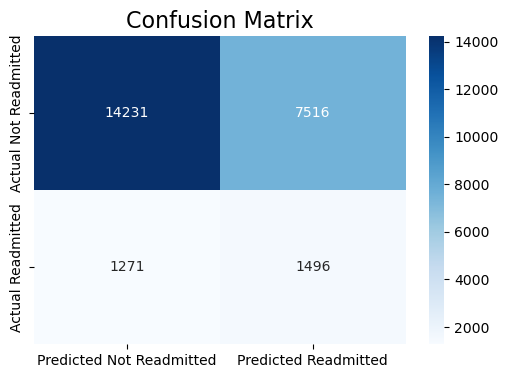


Insight: The confusion matrix shows the exact number of correct and incorrect predictions for each class.


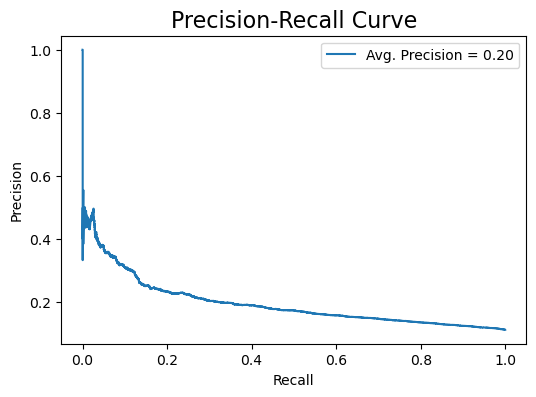

Insight: The PR curve helps you understand the trade-off between identifying all true positives (recall) and being correct when you make a positive prediction (precision).


In [31]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score


print("--- Final Model Evaluation on the Test Set ---")

# --- Make predictions on the test data ---
X_test_safe = X_test.copy()
X_test_safe.columns = [col.replace('[', 'l').replace(']', '').replace('<', 'lt').replace('>', 'gt').replace(' ', '_') for col in X_test_safe.columns]

y_pred_proba = random_search.best_estimator_.predict_proba(X_test_safe)[:, 1] # Probabilities for the positive class
y_pred_class = random_search.best_estimator_.predict(X_test_safe) # Final class predictions (0 or 1)

# --- Calculate and Print Metrics ---
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score on Test Set: {test_auc:.4f}")
print("This score is very close to your cross-validation score, which means your model is generalizing well!")

print("\nClassification Report:")
# This report shows precision, recall, and f1-score for each class
print(classification_report(y_test, y_pred_class, target_names=['Not Readmitted', 'Readmitted']))

# --- Visualize the Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Not Readmitted', 'Predicted Readmitted'], 
            yticklabels=['Actual Not Readmitted', 'Actual Readmitted'])
plt.title('Confusion Matrix', fontsize=16)
plt.show()
print("\nInsight: The confusion matrix shows the exact number of correct and incorrect predictions for each class.")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'Avg. Precision = {avg_precision:.2f}')
plt.title('Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
print("Insight: The PR curve helps you understand the trade-off between identifying all true positives (recall) and being correct when you make a positive prediction (precision).")


--- Interpreting Model Predictions with SHAP ---


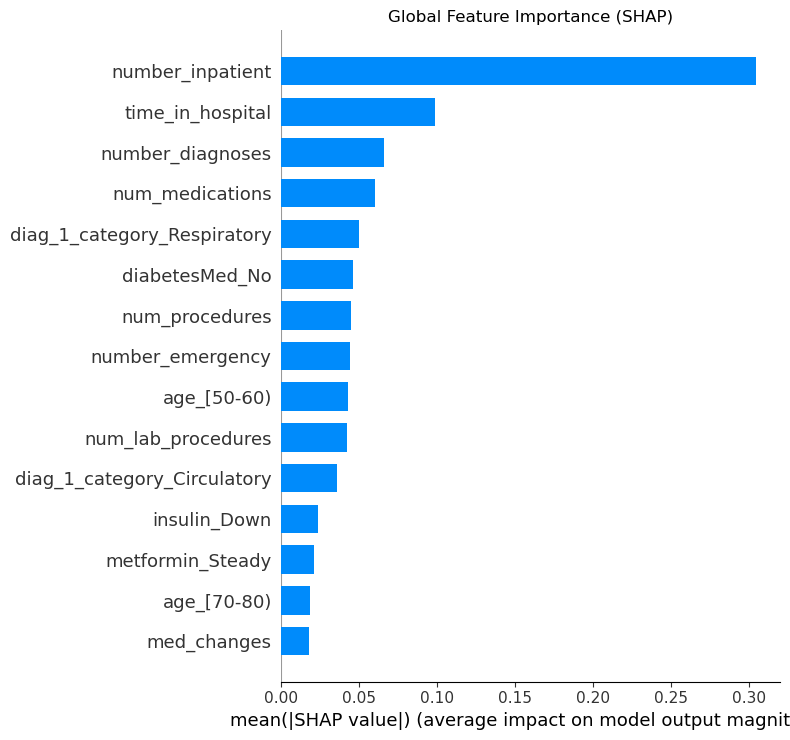

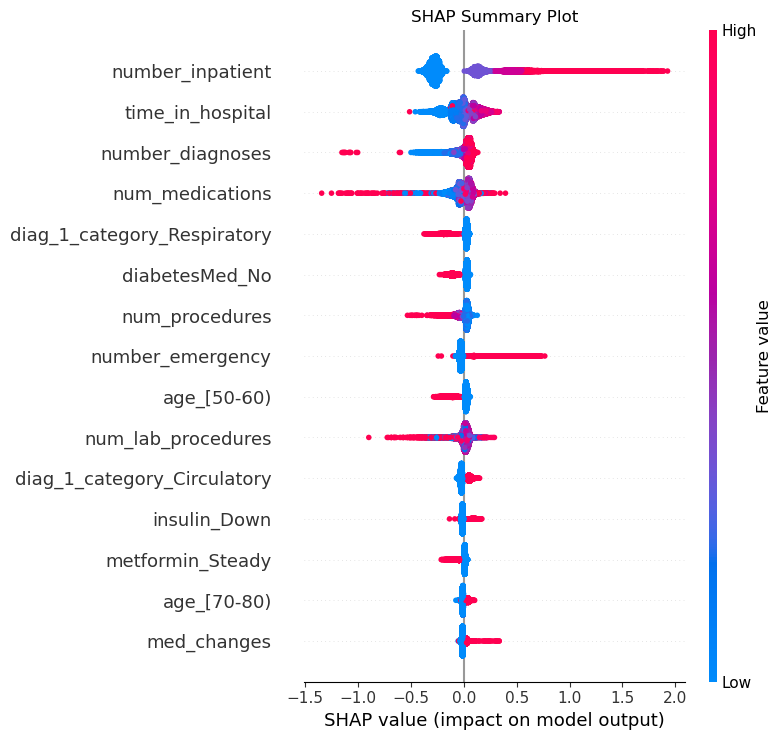


How to Read the Beeswarm Plot:
- Features are ranked by importance from top to bottom.
- A red dot on the right side of the center line means a high value for that feature increased the risk of readmission.
- A blue dot on the left side means a low value for that feature decreased the risk of readmission.


In [35]:
print("\n--- Interpreting Model Predictions with SHAP ---")

explainer=shap.TreeExplainer(random_search.best_estimator_)

# Ensure feature names are compatible
X_test_safe=X_test.copy()
X_test_safe.columns=[col.replace('[','l').replace(']','').replace('<','lt').replace('>','gt').replace(' ','_') for col in X_test_safe.columns]

shap_values=explainer.shap_values(X_test_safe)

plt.title('Global Feature Importance (SHAP)',fontsize=12)
shap.summary_plot(shap_values,X_test, plot_type="bar",max_display=15)

plt.title('SHAP Summary Plot',fontsize=12)
shap.summary_plot(shap_values,X_test,max_display=15)

print("\nHow to Read the Beeswarm Plot:")
print("- Features are ranked by importance from top to bottom.")
print("- A red dot on the right side of the center line means a high value for that feature increased the risk of readmission.")
print("- A blue dot on the left side means a low value for that feature decreased the risk of readmission.")

In [38]:
print("--- Saving all necessary artifacts for deployment ---")

joblib.dump(random_search.best_estimator_,'xgb_model.joblib')
print("Model saved as 'xgb_model.joblib'")

joblib.dump(encoder,'one_hot_encoder.joblib')
print("Encoder saved as 'one_hot_encoder.joblib'")

joblib.dump(feature_names,'feature_names.joblib')
print("Feature names list saved as 'feature_names.joblib'")

joblib.dump(numerical_features.tolist(),'numerical_features.joblib')
print("Numerical features list saved as 'numerical_features.joblib'")

joblib.dump(categorical_features.tolist(),'categorical_features.joblib')
print("Categorical features list saved as 'categorical_features.joblib'")

print("\nAll artifacts are successfully saved and ready for deployment!")

--- Saving all necessary artifacts for deployment ---
Model saved as 'xgb_model.joblib'
Encoder saved as 'one_hot_encoder.joblib'
Feature names list saved as 'feature_names.joblib'
Numerical features list saved as 'numerical_features.joblib'
Categorical features list saved as 'categorical_features.joblib'

All artifacts are successfully saved and ready for deployment!


In [40]:
import shap
import joblib

# Use the trained XGBoost model from RandomizedSearchCV
explainer = shap.TreeExplainer(random_search.best_estimator_)
joblib.dump(explainer, 'shap_explainer.joblib')
print("✅ SHAP explainer saved successfully as 'shap_explainer.joblib'")

✅ SHAP explainer saved successfully as 'shap_explainer.joblib'
